<h1><center><b>Appendix A</b></center></h1>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import product
import plotly.express as px
from scipy.stats import pearsonr, spearmanr, linregress


pd.options.mode.chained_assignment = None

Muhammad Hassan Nishat 1005835250 & Arjun Puri 1004707490

Required Data:

CLICS Database: https://clics.clld.org/

Word Association Data (SWOW-EN.R100.csv): https://osf.io/hjvm5/

Base Lexicon Files: https://github.com/hassan3301/COG260-Data.git



In [32]:
df = pd.read_csv("df_all_raw.csv")
df.columns = list(map(str.lower, df.columns))
df = df.drop(columns=['dataset_id', 'form_id', 'form', 'gloss_in_source', 'iso639p3code', 'mrc_word', 'kucera_francis_frequency'])

/var/folders/6j/k_ngy9gs69sckj60lmgylm1r0000gn/T/ipykernel_47912/2801652837.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("df_all_raw.csv")


In [18]:
def per_lang_colexification(curr_df):
    """
    Calculate the colexification frequency of pairs of concepts present in the current language.
    """
    all_combos_dict = {}
    # We iterate through each row, which has the concepts associated with a specific word
    for i, row in curr_df.iterrows():
        # Get the current set of concepts
        a = row['concepticon_gloss']
        # Create all possible unique combinations of concepts, where each pair is alphabetically sorted
        combos = list(set(map(lambda x: tuple(sorted(x)), product(a, a))))
        # Ensure the concepts in the pair are not identical
        combos = [combo for combo in combos if combo[0] != combo[1]]
        # Add counts for a pair of combinations being colexified
        for combo in combos:
            if combo in all_combos_dict:
                all_combos_dict[combo] += 1
            else:
                all_combos_dict[combo] = 1

    # Create a DataFrame out of our dictionary and return the colexification counts for two concepts
    tmp = pd.DataFrame.from_dict(all_combos_dict, "index").reset_index()
    per_lang = pd.DataFrame(tmp['index'].tolist(), columns=['concept_1', "concept_2"])
    per_lang['colexification_count'] = tmp[0]
    return per_lang

In [19]:
def main():
    all_dfs = []
    for variety in tqdm(df['variety'].unique()):
        sub = df[df['variety'] == variety]
        agg = sub.groupby("clics_form")[['concepticon_gloss', 'concepticon_id']].agg(list)
        agg['num_concepts'] = agg['concepticon_gloss'].apply(lambda x: len(set(x)))
        colex = agg[agg['num_concepts']>1]
        colex['concepticon_gloss'] = colex['concepticon_gloss'].apply(lambda x: sorted(list(set(x))))
        # We skip any language where no concepts are colexified
        if colex.shape[0] == 0:
            continue
        curr_df = per_lang_colexification(colex)
        all_dfs.append(curr_df)
    mega = pd.concat(all_dfs)
    colex_counts = mega.groupby(["concept_1", "concept_2"]).sum().reset_index()
    return colex_counts

In [20]:
colex_counts = main()

100%|██████████| 3050/3050 [03:17<00:00, 15.43it/s]


In [15]:
assoc_en = pd.read_csv('SWOW-EN.R100.csv')
assoc = assoc_en[assoc_en.columns[9:]]
assoc


,cue,R1,R2,R3
0,although,nevertheless,yet,but
1,deal,no,cards,shake
2,music,notes,band,rhythm
3,inform,tell,rat on,NaN
4,way,path,via,method
...,...,...,...,...
1228195,strange,mask,weird,stranger
1228196,sunset,sea,sky,clause
1228197,useless,pitty,worthless,worth
1228198,volume,loud,music,key


In [21]:
colexarr =[]
for index, row in colex_counts.iterrows():
    colexarr.append([str(row['concept_1']).lower(), str(row['concept_2']).lower()])


In [22]:
assocarr = []
for index, row in assoc.iterrows():
    for i in range(3):
        assocarr.append([str(row['cue']).lower(), str(row['R'+str(i+1)]).lower()])

In [23]:
assocarr_R1 = []
for index, row in assoc.iterrows():
    assocarr_R1.append([str(row['cue']).lower(), str(row['R1']).lower()])

In [ ]:
base_lexicon = []
for i in tqdm(assocarr):
    if i in colexarr or [i[1], i[0]] in colexarr:
        base_lexicon.append(i)

These 4 code cells below create lists of colexification and association counts for our base lexicon. There is also an option to import this data from csv files below.

In [ ]:
base_lexicon_colex = []

for i in tqdm(range(len(base_lexicon))):
    query1 = "concept_1=='{}' and concept_2=='{}'".format(base_lexicon[i][0].upper(),base_lexicon[i][1].upper())
    query2 = "concept_1=='{}' and concept_2=='{}'".format(base_lexicon[i][1].upper(),base_lexicon[i][0].upper())
    df1 = colex_counts.query(query1)
    
    if not df1.empty:
        base_lexicon_colex.append(df1['colexification_count'])
    else:
        df2 = colex_counts.query(query2)
        base_lexicon_colex.append(df2['colexification_count'])

In [ ]:
base_lexicon_assoc = []
for i in tqdm(base_lexicon):
    count = 0
    for j in assocarr:
        if (i[0] == j[0] and i[1] == j[1]):
            count+=1
    base_lexicon_assoc.append(count)

In [ ]:
base_lexicon_assoc_R1 = []
for i in tqdm(base_lexicon):
    count = 0
    for j in assocarr_R1:
        if (i[0] == j[0] and i[1] == j[1]):
            count+=1
    base_lexicon_assoc_R1.append(count)

Run the below code to import the csv files filled with the lists created by the code above.

In [33]:
import csv
with open('base_lexicon.csv', newline='') as f:
    reader = csv.reader(f)
    base_lexicon = list(reader)

for i in range(len(base_lexicon)):
    base_lexicon[i][1] = base_lexicon[i][1].strip()

del base_lexicon[33082]

with open('base_lexicon_assoc.csv', newline='') as f:
    reader = csv.reader(f)
    base_lexicon_assoc = list(reader)
del base_lexicon_assoc[33082]

with open('base_lexicon_assoc_R1.csv', newline='') as f:
    reader = csv.reader(f)
    base_lexicon_assoc_R1 = list(reader)
del base_lexicon_assoc_R1[33082]

with open('base_lexicon_colex.csv', newline='') as f:
    reader = csv.reader(f)
    base_lexicon_colex = list(reader)

In [34]:
base_lexicon_colex = [int(item) for sublist in base_lexicon_colex for item in sublist]
base_lexicon_assoc = [int(item) for sublist in base_lexicon_assoc for item in sublist]
base_lexicon_assoc_R1 = [int(item) for sublist in base_lexicon_assoc_R1 for item in sublist]

In [35]:
d = {'Base_Lexicon': base_lexicon, 'Colex_Counts': base_lexicon_colex, 'Assoc': base_lexicon_assoc, 'Assoc_R1': base_lexicon_assoc_R1}
df2 = pd.DataFrame(data=d)
df2

,Base_Lexicon,Colex_Counts,Assoc,Assoc_R1
0,"[paper, book]",67,6,3
1,"[town, village]",68,29,11
2,"[mind, brain]",24,55,22
3,"[read, learn]",63,10,2
4,"[board, wood]",19,35,9
...,...,...,...,...
71898,"[preserve, keep]",166,30,20
71899,"[stream, river]",32,52,30
71900,"[toe, foot]",5,65,49
71901,"[breast, chicken]",1,26,7


Text(0, 0.5, 'Colexification Count')

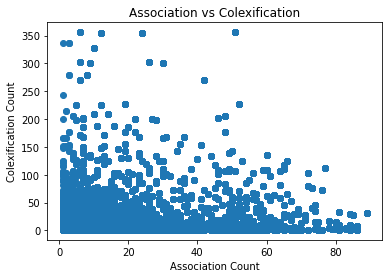

In [36]:
plt.scatter(base_lexicon_assoc, base_lexicon_colex)
plt.title('Association vs Colexification')
plt.xlabel("Association Count")
plt.ylabel("Colexification Count")


In [37]:
spearmanR123 = spearmanr(base_lexicon_assoc, base_lexicon_colex)
spearmanR1 = spearmanr(base_lexicon_assoc_R1, base_lexicon_colex)

In [38]:
print(spearmanR123, spearmanR1)

SpearmanrResult(correlation=0.24433085061261967, pvalue=0.0) SpearmanrResult(correlation=0.24878294815024218, pvalue=0.0)


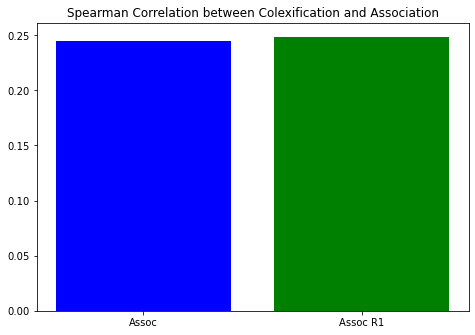

In [40]:
R123corr = spearmanR123[0]
R1corr = spearmanR1[0]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = ['Assoc', 'Assoc R1']
y = [R123corr, R1corr]
ax.bar(x, y, color=['blue', 'green'])
plt.title('Spearman Correlation between Colexification and Association')
plt.show()